In [ ]:
!pip install pretrainedmodels

In [ ]:
import numpy as np 
import pandas as pd 
from fastai.vision import *
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
#import os
import gc

from fastai.vision.models.cadene_models import *

import pretrainedmodels
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
path = Path('/content/drive/My Drive/data/plant_pathology/')

In [ ]:
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sample_df = pd.read_csv(path/'sample_submission.csv')

In [ ]:
test_df['image_id'] = 'images/' + test_df['image_id'] + '.jpg'

In [ ]:
test_data = ImageList.from_df(test_df, path)

In [ ]:
#transformations
tfms = get_transforms(do_flip = True,
                      flip_vert=True, 
                      max_lighting=0.1, 
                      max_zoom=1.05,
                      max_warp=0.,
                      max_rotate=15,
                      p_affine=0.75,
                      p_lighting=0.75) 

In [ ]:
src = (ImageImageList.from_csv(path,'train.csv', folder='images', suffix='.jpg')
              .split_by_rand_pct(0.2)
              .label_from_df(cols=[1,2,3,4])
              .add_test(test_data))

In [ ]:
train_data = (src
              .transform(tfms, size=(64,64))
              .databunch()
              .normalize(imagenet_stats))

In [ ]:
learn = create_cnn(train_data,models.alexnet, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.45E-02


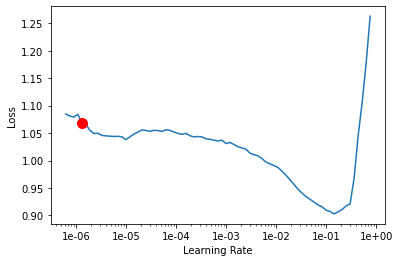

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(30, max_lr=slice(1e-06, 1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,1.058025,0.861205,0.194368,04:48
1,1.055009,0.848449,0.194368,01:37
2,1.041669,0.842666,0.173077,01:39
3,1.043390,0.835462,0.186813,01:38
4,1.047051,0.838040,0.197115,01:37
5,1.034489,0.828781,0.175137,01:39
6,1.033885,0.823857,0.182005,01:37
7,1.033891,0.822594,0.178571,01:37
8,1.032348,0.820948,0.179945,01:39
9,1.033125,0.806630,0.175824,01:37


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 4.79E-03


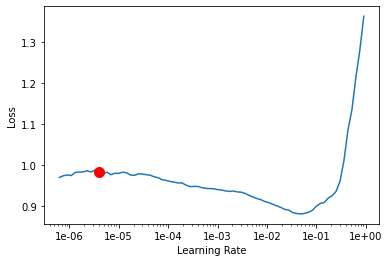

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(30,max_lr=slice(1e-06, 1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.978610,0.773922,0.176511,01:38
1,0.972610,0.781143,0.176511,01:38
2,0.964534,0.781237,0.170330,01:39
3,0.966907,0.772487,0.166209,01:38
4,0.963074,0.766350,0.184066,01:36
5,0.957205,0.773957,0.181319,01:37
6,0.956404,0.771408,0.175824,01:38
7,0.963249,0.760427,0.171703,01:36
8,0.958297,0.764915,0.189560,01:37
9,0.953109,0.765370,0.176511,01:37


In [ ]:
preds, y = learn.get_preds(DatasetType.Test)

In [ ]:
sample_df.iloc[:,1:] = preds.numpy()


In [ ]:
sample_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.525501,0.425729,0.633041,0.636068
1,Test_1,0.209283,0.395181,0.704840,0.609670
2,Test_2,0.425626,0.224324,0.488427,0.702921
3,Test_3,0.730304,0.181611,0.395094,0.890228
4,Test_4,0.726897,0.401316,0.887316,0.593839


In [ ]:
sample_df.to_csv(path/'submission_alexnet_fastai.csv', index=False)
#Score 55% 